<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/malariaPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import albumentations as A

In [4]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteRAQKSV/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp98zwd0pqtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
# dataset = tf.data.Dataset.range(10)
# print(list(dataset.as_numpy_iterator()))

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Dataset Visualization


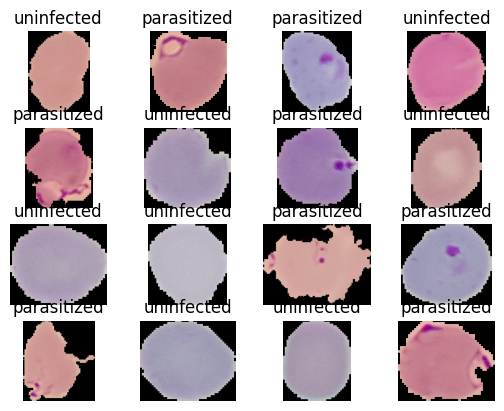

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [9]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing

In [10]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [11]:
original_image, label = next(iter(train_dataset))

In [12]:
augmented_image = tf.image.flip_left_right(original_image)
augmented_image1 = tf.image.random_flip_up_down(original_image)
augmented_image2 = tf.image.adjust_brightness(original_image, delta = 0.8)
augmented_image3 = tf.image.random_saturation(original_image, lower = 2, upper = 12)

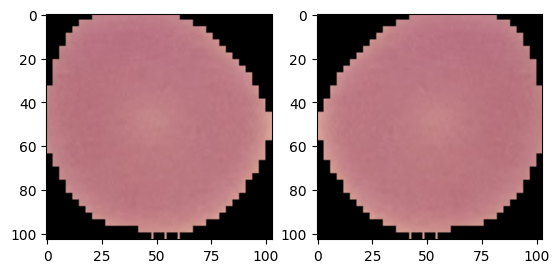

In [13]:
visualize(original_image, augmented_image)

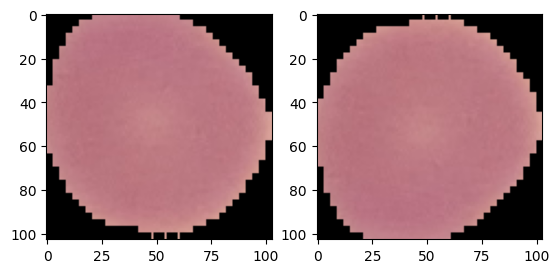

In [14]:
visualize(original_image, augmented_image1)

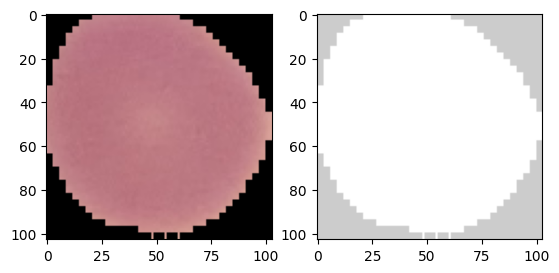

In [15]:
visualize(original_image, augmented_image2)

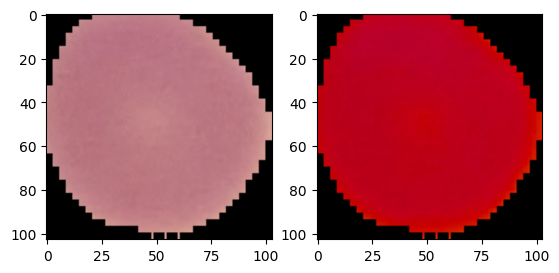

In [16]:
visualize(original_image, augmented_image3)

In [17]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [18]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

In [19]:
# tf.image augment
def augment(image, label):

  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [20]:
# tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501),),
    RandomFlip(mode='horizontal',),
])

def augment_layer(image, labels):
  return augment_layers(resize_rescale(image), training = True), labels

# Albumentation

In [21]:
# RandomRotate90
# HorizontalFLip
# VerticalFlip
# RandomGridShuffle
# RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5)

In [22]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.RandomRotate90(),

    A.OneOf([A.HorizontalFlip(),
            A.VerticalFlip(),]),

    # RandomGridShuffle(),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                             contrast_limit=0.2,
                             brightness_by_max=True,
                             always_apply=False, p=0.5),
    # A.Cutout(),
    A.Sharpen(alpha= (0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p = 0.5)
])

In [23]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [24]:
def process_data(image, label):
  aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
  return aug_img, label

In [25]:
# test_dataset = test_dataset.map(resize_rescale_layers)
# train_dataset
# val_dataset

In [26]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [27]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration=True)
    # .map(process_data)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
    )
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
# im, _ = next(iter(train_dataset))
# plt.imshow(im[0])

In [30]:
# plt.figure(figsize=(10, 10))

# for i in range(1, 32):
#   plt.subplot(8, 4, i)
#   plt.imshow(im[i])

In [31]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration=True)
    # .map(resize_rescale_layers)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
    )
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Squential API Model

In [32]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Flatten(),
    Dense(1000, activation = "relu"),
    BatchNormalization(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),

])
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

# Functional API Model

In [33]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")

feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [34]:
# Creating my feature extractor using a sequential model
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

])
feature_extractor_seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [35]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)
x = Flatten()(x)
x = Dense(1000, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_8 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 100)               100100    
                                                       

# Model subclassing

In [36]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)

    self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [37]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)
x = Flatten()(x)
x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [38]:
# self, filters, kernel_size, strides, padding, activation, pool_size

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

# Custom Layers

In [39]:
from IPython.core.events import pre_execute
# , initializer = "random_normal"
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), trainable=True)
    self.b = self.add_weight(shape = (self.output_units,), trainable=True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if self.activation == "relu":
      return tf.nn.relu(pre_output)
    elif self.activation == "sigmoid":
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [40]:
IM_SIZE =224
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Flatten(),
    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),

])
lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [41]:
# self, filters, kernel_size, strides, padding, activation, pool_size

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [42]:
from keras.src import regularizers
IM_SIZE = 224
dropout_rate = 0.5
regularization_rate = 0.01

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),

    resize_rescale_layers,
    augment_layers,

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu',
           kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu',
           kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = "relu", kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = "relu", kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),

])
lenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_26 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)     

# Error Sunctioning

In [43]:
# We generally use BinaryCrossEntropy loss
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy() # from_logits=True
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [44]:
#  metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
#                 BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [45]:
from keras.api._v2.keras import metrics
from keras.src.losses import BinaryCrossentropy
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [46]:
# def custom_bce():
#   bce = BinaryCrossentropy()
#   return bce(y_true, y_pred)

In [56]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = BinaryCrossentropy(),
              # loss = custom_bce,
              metrics = metrics,
              run_eagerly=False
                    )
              # metrics = RootMeanSquaredError()

# Callbacks

In [48]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch + 1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch + 1, logs))

CSVLogger

In [49]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

Early Stopping

In [50]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

LearningRateScheduler Callback

In [51]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

Model check pointing

In [52]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

ReduceLearningRateOnPlateau

In [53]:
from keras.src.callbacks import ReduceLROnPlateau
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factory=0.1, patience=2, verbose=1
)

In [ ]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset, epochs = 3, verbose = 1, callbacks = [plateau_callback])

Epoch 1/3
 4107/22046 [====>.........................] - ETA: 34:43 - loss: 1.3401 - tp: 1080.0000 - fp: 1080.0000 - tn: 959.0000 - fn: 988.0000 - accuracy: 0.4965 - precision: 0.5000 - recall: 0.5222 - auc: 0.4929

Model evaluation and testing

# Visualization

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)
test_dataset

In [ ]:
lenet_model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

# Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(inp)

In [ ]:
# print(np.array(inp).shape)
# print(np.array(inp)[:, 0, ...].shape)

In [ ]:
print(labels)
labels = np.array([i[0] for i in labels])
print(labels)

In [ ]:
predicted = lenet_model.predict(np.array(inp)[:, 0, ...])

In [ ]:
print(predicted[:, 0].shape)
print(predicted[:, 0])

# Testing with own image

In [ ]:
# image = cv2.imread('cell.jpg')
# print(image)
# image = tf.expand_dims(image, axis = 0)
# lenet_model.predict(image)

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC plot

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')